# Gaussian Process

## Kernel function or covariances function

### Squared exponential kernel

In [257]:
import numpy as np
import matplotlib.pyplot as plt

In [258]:
def kernel(x):
    return np.exp(-x**2)

Text(0.5, 1.0, 'Squared exponential kernel')

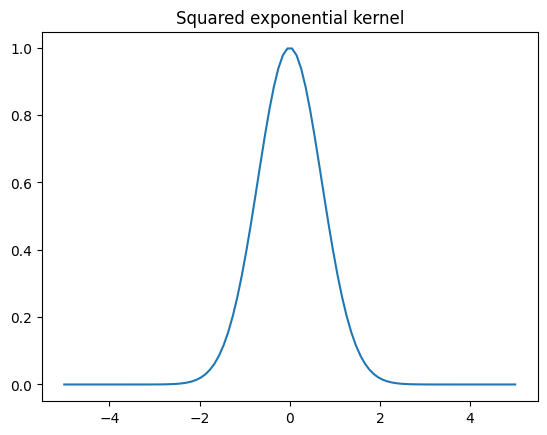

In [259]:
X = np.linspace(-5, 5, 100).reshape(-1, 1)
K = kernel(X)
plt.plot(X, K)
plt.title("Squared exponential kernel")

## Drawing from Gaussian Process Prior

In [260]:
np.random.seed(8)

In [261]:
n = 100 
X_test = np.linspace(-5, 5, n).reshape(-1, 1)
X_test.shape

(100, 1)

Kernel funtion: squared exponential distance between two locations

In [262]:
def kernel(a, b):
    sq_distance = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(-sq_distance)

In [263]:
# Calculate the pairwise distance, resulting in a n*n matrix
K = kernel(X_test, X_test)

# adding a small number along the diagonal elements to ensure 
# cholesky decomposition works 
L = np.linalg.cholesky(K + 1e-10*np.eye(n))

# Calculating funtional samples by multiplying the 
# standar deviation with standard normal samples 
samples = np.dot(L, np.random.normal(size = (n, 5)))

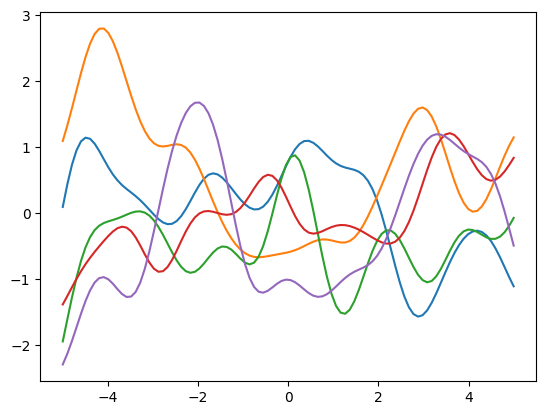

In [264]:
plt.plot(X_test, samples)

Gaussian Kernel or RBF kernel

$$\kappa(x_i, x_j) = \sigma_f^2\exp(-\frac{1}{2l^2}||x_i-x_j||^2)$$

In [265]:
def ise_kernel(X1, X2, l = 1.0, sigma_f = 1.0):
    sq_distance = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2*np.dot(X1, X2.T)
    return sigma_f**2 *  np.exp(-0.5/l**2 * sq_distance)

In [266]:
# mean and covariance of the prior
mu = np.zeros(X_test.shape)
K = ise_kernel(X_test, X_test)

In [267]:
# draw samples from the prior using multivariate normal from numpy
# Convert mu from shape (n, 1) to (n,)
samples = np.random.multivariate_normal(mean = mu.ravel(), cov = K, size = 5)

Plotting GP prior mean function, uncertainty region and samples

In [268]:
def plot_gp(mu, cov, X, X_train = None, Y_train = None, samples = []):
    X = X.ravel() # convert (n, 1) to (n, )
    mu = mu.ravel()
    # 95% confidence interval 
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha = 0.1)
    plt.plot(X, mu, label = "Mean")
    for i, sample in enumerate(samples): 
        plt.plot(X, sample, lw = 1, ls = '--', label = f'Sample {i+1}')
    # plot observations is available
    if X_train is not None: 
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

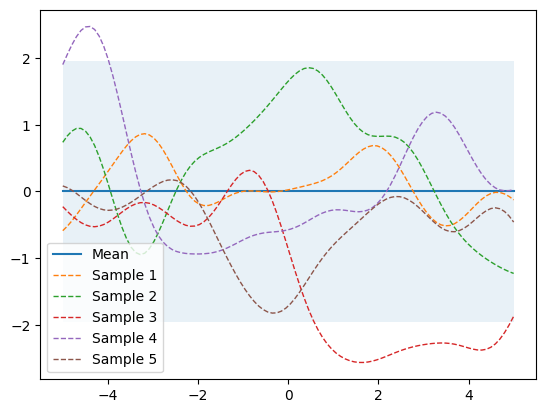

In [269]:
plot_gp(mu, K, X_test, samples = samples)

Obtaining GP Posterior with Noise-Free Observations

In [270]:
from numpy.linalg import inv

$$\mu_*=\textbf{K}_*^T\textbf{K}_y^{-1}\textbf{y}$$
$${\sum}_* = \textbf{K}_{**}-\textbf{K}^T_*\textbf{K}_y^{-1}\textbf{K}_*    $$

In [271]:
def update_posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y = 1e-8):
    """
    Computes the mean vector and covariance matrix of the posterior 
    distribution
    from m training data X_train and Y_train and n new inputs X_s.
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Observation noise parameter.
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n)
    """
    # Covariance matrix for observed inputs
    K = ise_kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    # Cross variance between observed and new inputs
    K_s = ise_kernel(X_train, X_s, l, sigma_f)
    # Covariance matrix for new inputs
    K_ss = ise_kernel(X_s, X_s, l, sigma_f) + 1e-8 ** np.eye(len(X_s))    
    # Compute inverse of covariance 
    K_inv = inv(K)
    # Posterior mean vector bases on derived closed-form formula 
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    # Posterior covariance matrix based on derived closed-form formula
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    return mu_s, cov_s

Generating samples from posterior GP

In [272]:
# noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.cos(X_train)

# Compute mean and convariance of posterior distribution 
mu_s, cov_s = update_posterior(X_test, X_train, Y_train)

# Generate five samples from multivariate normal distribution
samples_2 = np.random.multivariate_normal(mean = mu_s.ravel(), cov = cov_s, size = 5)

C:\Users\trek2\AppData\Local\Temp\ipykernel_14232\847887519.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples_2 = np.random.multivariate_normal(mean = mu_s.ravel(), cov = cov_s, size = 5)


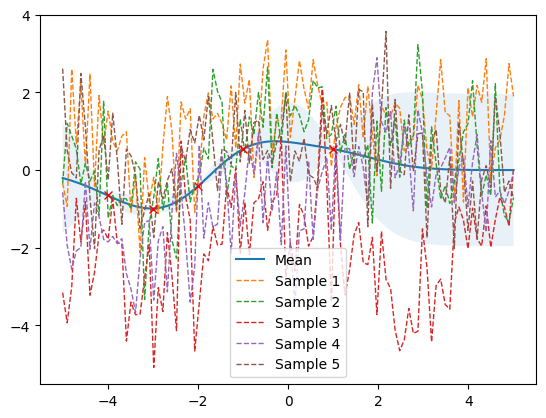

In [273]:
plot_gp(mu_s, cov_s, X_test, X_train = X_train, Y_train = Y_train, samples = samples_2)

Working with Noisy Observations

In [274]:
# set standart deviation of the noise 
noise = 0.5
#  Create noisy training data
Y_train = np.cos(X_train) + noise * np.random.randn(*X_train.shape)
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = update_posterior(X_test, X_train, Y_train, sigma_y = noise)
# Generate five samples
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)

C:\Users\trek2\AppData\Local\Temp\ipykernel_14232\900681325.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)


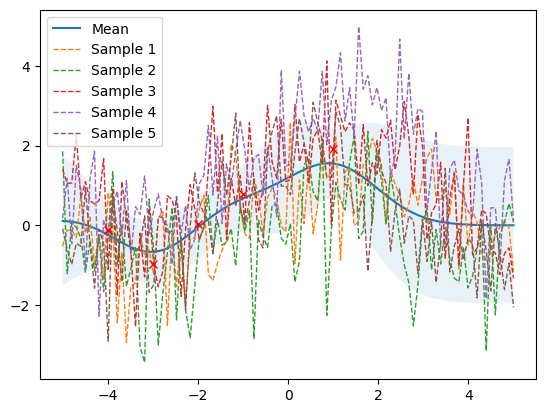

In [275]:
plot_gp(mu_s, cov_s, X_test, X_train = X_train, Y_train = Y_train, samples = samples)

In [276]:
# set standart deviation of the noise 
noise = 1.0
#  Create noisy training data
Y_train = np.cos(X_train) + noise * np.random.randn(*X_train.shape)
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = update_posterior(X_test, X_train, Y_train, sigma_y = noise)
# Generate five samples
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)

C:\Users\trek2\AppData\Local\Temp\ipykernel_14232\49229089.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)


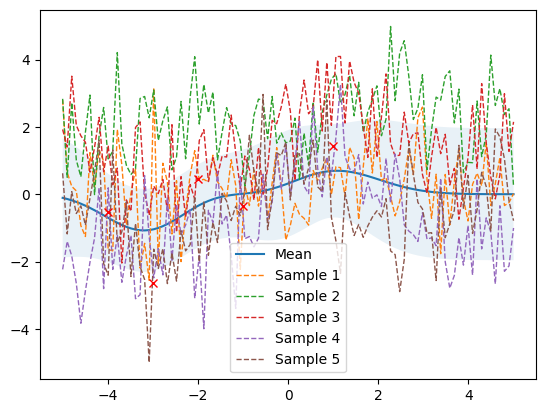

In [277]:
plot_gp(mu_s, cov_s, X_test, X_train = X_train, Y_train = Y_train, samples = samples)

Experimenting with Different Kernel Parameters

In [278]:
params = [(0.2, 1.0), (0.4, 1.0), (0.6, 1.0), (0.8, 1.0)]
#params = [(i, j) for i in np.arange(0.1, 1, 0.1) for j in np.arange(0.1, 1, 0.1)]

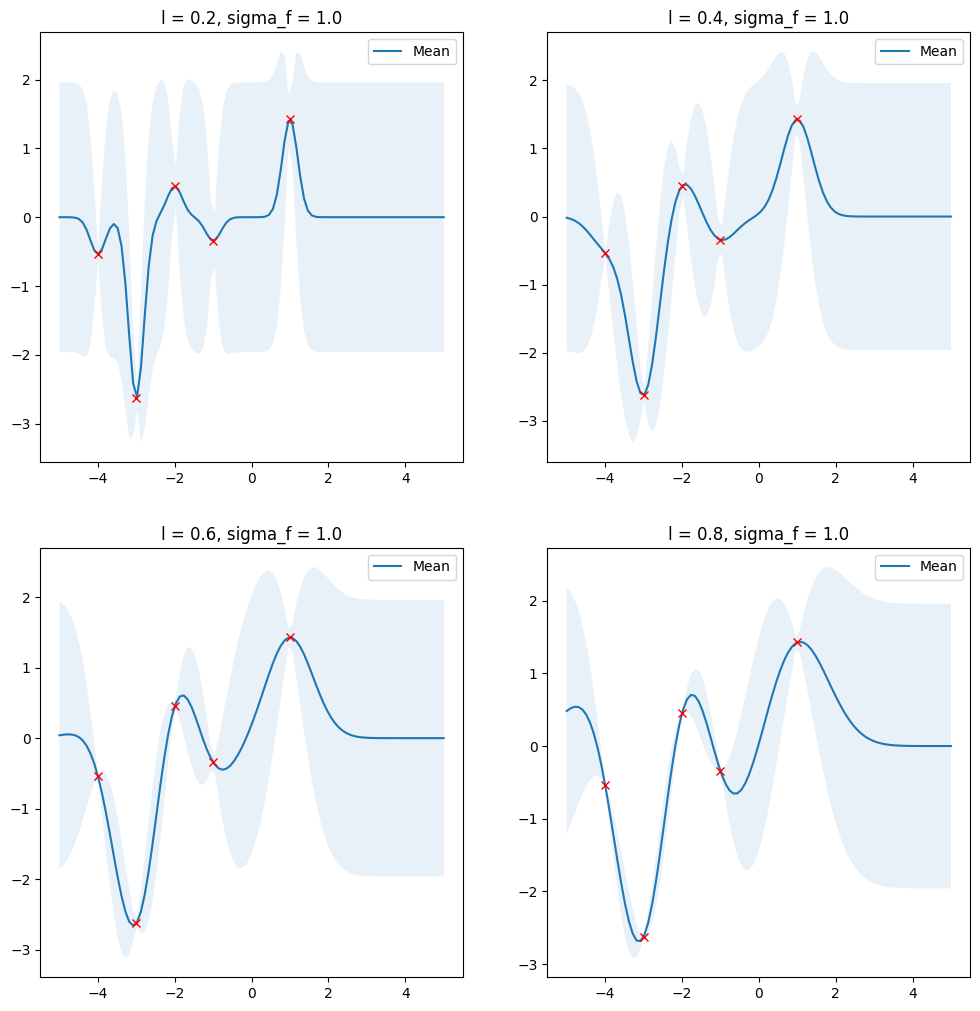

In [279]:
plt.figure(figsize = (12, 5))
for i, (l, sigma_f) in enumerate(params):
    mu_s, cov_s = update_posterior(X_test, X_train, Y_train, l = l, sigma_f = sigma_f)
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(top = 2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}')
    plot_gp(mu_s, cov_s, X_test, X_train = X_train, Y_train = Y_train)

In [280]:
params = [(1.0, 0.2), (1.0, 0.4), (1.0, 0.6), (1.0, 0.8)]

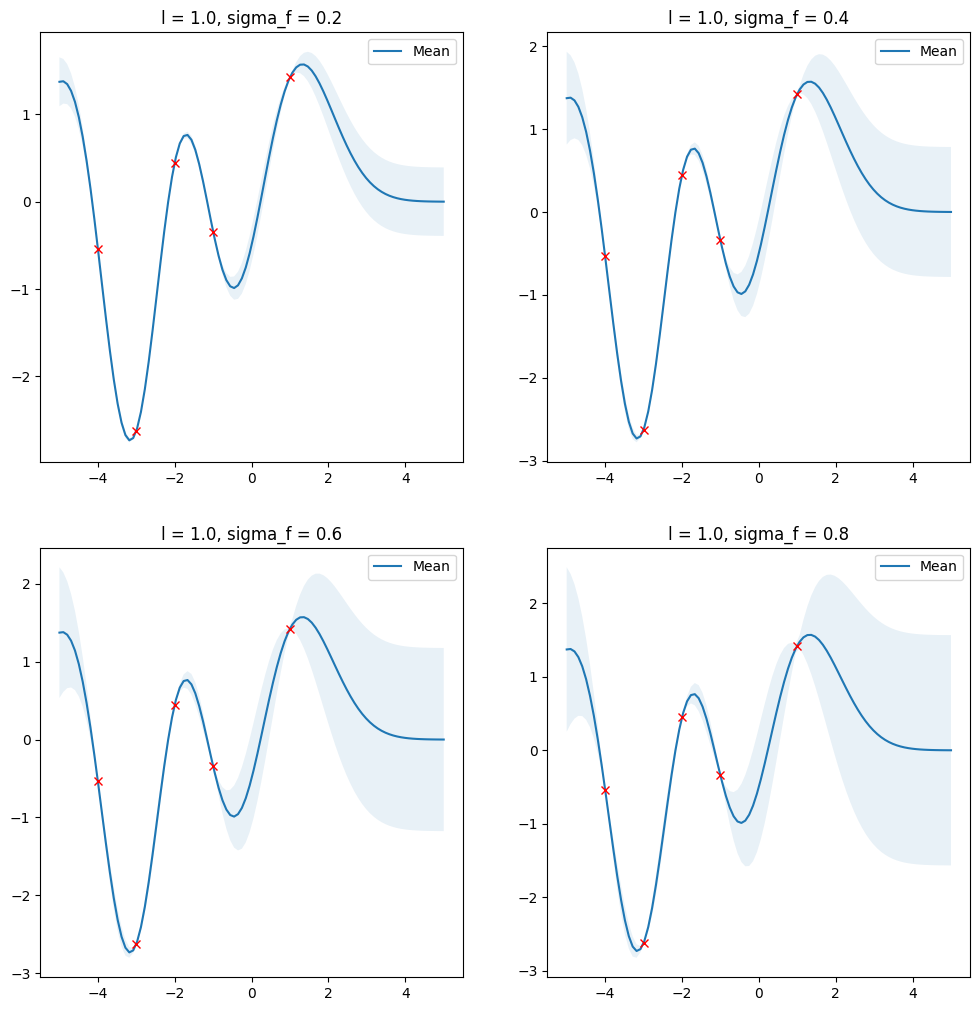

In [281]:
plt.figure(figsize = (12, 5))
for i, (l, sigma_f) in enumerate(params):
    mu_s, cov_s = update_posterior(X_test, X_train, Y_train, l = l, sigma_f = sigma_f)
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(top = 2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}')
    plot_gp(mu_s, cov_s, X_test, X_train = X_train, Y_train = Y_train)